<a href="https://colab.research.google.com/github/gkrry2723/WalkWith/blob/main/walkWith_crosswalk_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import drive

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
%cd gdrive/MyDrive/colab_zaryo/

/content/gdrive/MyDrive/colab_zaryo


In [3]:
!ls

신호등	      crosswalk_dot4.csv  crosswalk_pic  new_save  test_pic
4resized_pic  crosswalk_dot8.csv  model		 save	   test_pic_resize
8resized_pic  crosswalk_dot.csv   new		 test.csv


# train data 준비
- csv 파일 열고 output인 y 값에 넣기

In [ ]:
# csv 파일 열기
file_data   = "./crosswalk_dot8.csv"
#file_data   = "./new/8new_dot.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

yy = []
for line in data:
    line_data   = line.split(',')
    tmp_y = line_data
    tmp_y[8] = tmp_y[8][:-1]
    tmp_y = list(map(int, tmp_y))
    label       = line_data[0]
    
    if line_data[0] == "51":
      continue
    else:
      print(line_data[0])
      yy.append(tmp_y)

print(yy)

# cnn layer 이후 shape 계산하는 코드

In [35]:
# H = 90
# W = 160

# H = 4
# W = 13

H = 17
W = 35

kernel_size = (5,5)
stride = (2,2)
padding = (0,0)
dilation = (1,1)


kernel_size = (3,3)
stride = (1,1)
padding = (0,0)
dilation = (1,1)

Hout = (((H + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) -1)/stride[0])+1 )// 1
Wout = (((W + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) -1)/stride[1])+1 )// 1

print(Hout, Wout)

15.0 33.0


# **1. 모델**

- nvidia의 end to end 모델을 참고함.
- https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf
- convolution layer -> fully connected layer

In [6]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

use_cuda = torch.cuda.is_available()

class train_model(nn.Module):
    def __init__(self):
        super(train_model, self).__init__()
        conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=(5, 5), stride=(2, 2), padding=(0, 0), dilation=(1, 1))
        conv2 = nn.Conv2d(in_channels=24, out_channels=36, kernel_size=(5, 5), stride=(2, 2), padding=(0, 0), dilation=(1, 1)) 
        conv3 = nn.Conv2d(in_channels=36, out_channels=48, kernel_size=(5, 5), stride=(2, 2), padding=(0, 0), dilation=(1, 1)) 
        conv4 = nn.Conv2d(in_channels=48, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0), dilation=(1, 1)) 
        conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0), dilation=(1, 1)) 
        
        self.conv_module = nn.Sequential(
            conv1, nn.ReLU(),
            conv2, nn.ReLU(),
            conv3, nn.ReLU(),
            conv4, nn.ReLU(),
            conv5, nn.ReLU(),
        )
        
        fc1_1 = nn.Linear(3328, 1000)
        fc1_2 = nn.Linear(1000, 500)
        fc1_3 = nn.Linear(500, 100)
        fc1_4 = nn.Linear(100, 50)
        fc1_5 = nn.Linear(50, 20)
        fc1_6 = nn.Linear(20, 8)

        self.fc_module = nn.Sequential(
            fc1_1, nn.ReLU(),
            fc1_2, nn.ReLU(),
            fc1_3, nn.ReLU(),
            fc1_4, nn.ReLU(),
            fc1_5, nn.ReLU(),
            fc1_6
        )
 
    def forward(self, x):
        common = self.conv_module(x)
        common = torch.flatten(common, start_dim=1)
        x = self.fc_module(common)

        return x

# **2. train**

- pytorch library 사용

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import glob, csv, random, time, io, dill, os

import numpy as np
from PIL import Image

def study_model_save(epoch, batch_cnt, model):
    if not os.path.isdir("./new_save/"):
        os.mkdir("./new_save/")
    SavePath_main = os.getcwd()+"/new_save/main_model_"+str(epoch).zfill(6)+"_"+str(batch_cnt).zfill(6)+".pth"
    SaveBuffer = io.BytesIO()
    torch.save(model.state_dict(), SaveBuffer, pickle_module=dill)
    with open(SavePath_main, "wb") as f:
        f.write(SaveBuffer.getvalue())

def study_model_load(episode, model, cnt, device):
    LoadPath_main = os.getcwd()+"/new_save/main_model_"+str(episode).zfill(6)+"_"+str(cnt).zfill(6)+".pth"
    with open(LoadPath_main, 'rb') as f:
        LoadBuffer = io.BytesIO(f.read())
    model.load_state_dict(torch.load(LoadBuffer, map_location=device))
    return model


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_batch = []
y_batch = []
batch_size = 101
epochs = 5000
epoch = 1
cnt = 1

net= train_model().to(device)
#net = study_model_load(5000, net, 101, device).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

while (epoch < epochs):
    bc = 0
    for ccss in yy:
        if (cnt % batch_size) == 0:
            cnt = 1
            x = torch.FloatTensor(x_batch).to(device)
            y = torch.FloatTensor(y_batch).to(device)

            optimizer.zero_grad()
            output = net(x)
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()

            x_batch = []
            y_batch = []
            bc += 1

            print("epoch : {} / {} | loss : {}".format(epoch, epochs, loss / 100))
        name = "./new/new_8resized/"+str(ccss[0])+".jpg"
        img = Image.open(name)
        img = img.convert('YCbCr')
        img = np.array(img)
        img = img.transpose((2, 0, 1)) / 255.0
        img = x_batch.append(img.tolist())
        
        label_x = y_batch.append(ccss[1:])

        cnt += 1
        time.sleep(0.02)

    #print("epoch : {} / {} | loss : {}".format(epoch, epochs, loss / 100))
    time.sleep(1)
    epoch += 1

    if (epoch % 100) == 0:
      study_model_save(epoch, cnt, net)

epoch : 2 / 5000 | loss : 61.35856628417969
epoch : 3 / 5000 | loss : 61.16421890258789
epoch : 4 / 5000 | loss : 61.26341247558594
epoch : 5 / 5000 | loss : 61.309513092041016
epoch : 6 / 5000 | loss : 61.312400817871094
epoch : 7 / 5000 | loss : 61.304622650146484
epoch : 8 / 5000 | loss : 61.364601135253906
epoch : 9 / 5000 | loss : 61.392425537109375
epoch : 10 / 5000 | loss : 61.2750244140625
epoch : 11 / 5000 | loss : 61.32120132446289
epoch : 12 / 5000 | loss : 61.32502746582031
epoch : 13 / 5000 | loss : 61.358497619628906
epoch : 14 / 5000 | loss : 61.34305191040039
epoch : 15 / 5000 | loss : 61.2961540222168
epoch : 16 / 5000 | loss : 61.34141159057617
epoch : 17 / 5000 | loss : 61.40556716918945
epoch : 18 / 5000 | loss : 61.2713623046875
epoch : 19 / 5000 | loss : 61.37132263183594
epoch : 20 / 5000 | loss : 61.2962532043457
epoch : 21 / 5000 | loss : 61.31572341918945
epoch : 22 / 5000 | loss : 61.38157653808594
epoch : 23 / 5000 | loss : 61.28248596191406
epoch : 24 / 500

# **3. Test**

- train 했던 데이터로 1차 test

---------------------------------------------------------------
real : [39, 69, 71, 7, 39, 105, 89, 130]
e2e :  tensor([[ 44.4207,  67.0926,  71.7240,   2.6245,  46.2579, 110.2348,  73.2903,
         130.6272]], grad_fn=<AddmmBackward>)
[44.42070770263672, 67.0925521850586, 71.72402954101562, 2.6245076656341553, 46.257877349853516, 110.23481750488281, 73.29025268554688, 130.627197265625]


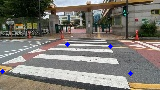

---------------------------------------------------------------
real : [50, 60, 84, 8, 50, 97, 81, 147]
e2e :  tensor([[ 55.2405,  57.2709,  78.4348,   4.9776,  54.7930,  99.1787,  76.6607,
         146.0131]], grad_fn=<AddmmBackward>)
[55.240478515625, 57.27090072631836, 78.43482208251953, 4.977564334869385, 54.7929573059082, 99.17867279052734, 76.66072082519531, 146.01312255859375]


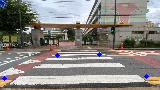

---------------------------------------------------------------
real : [49, 60, 84, 8, 49, 97, 82, 147]
e2e :  tensor([[ 53.7607,  58.8018,  77.8076,   5.3638,  53.4955, 100.5903,  75.8585,
         149.6381]], grad_fn=<AddmmBackward>)
[53.76073455810547, 58.80178451538086, 77.80755615234375, 5.3637871742248535, 53.495487213134766, 100.59026336669922, 75.85848999023438, 149.63812255859375]


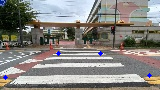

---------------------------------------------------------------
real : [47, 60, 78, 9, 46, 97, 78, 146]
e2e :  tensor([[ 50.8193,  59.7252,  75.0434,   5.9949,  50.7790,  99.9273,  73.1307,
         147.9642]], grad_fn=<AddmmBackward>)
[50.81932830810547, 59.72517776489258, 75.04337310791016, 5.994944095611572, 50.778995513916016, 99.92733764648438, 73.13065338134766, 147.9641876220703]


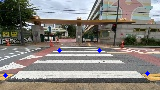

---------------------------------------------------------------
real : [47, 59, 82, 11, 48, 95, 78, 149]
e2e :  tensor([[ 52.3005,  57.3084,  75.1030,   6.8510,  51.7661,  96.0969,  72.5833,
         147.7276]], grad_fn=<AddmmBackward>)
[52.300537109375, 57.30839920043945, 75.10301208496094, 6.850978374481201, 51.76608657836914, 96.09686279296875, 72.5832748413086, 147.72755432128906]


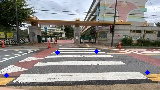

---------------------------------------------------------------
real : [53, 68, 74, 4, 52, 109, 70, 147]
e2e :  tensor([[ 50.0756,  66.1056,  76.1647,   6.2759,  50.6745, 107.6588,  75.3134,
         147.6544]], grad_fn=<AddmmBackward>)
[50.07561492919922, 66.10562133789062, 76.16468811035156, 6.275872707366943, 50.67452621459961, 107.65876770019531, 75.31336212158203, 147.65435791015625]


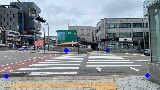

---------------------------------------------------------------
real : [57, 65, 76, 3, 55, 108, 70, 145]
e2e :  tensor([[ 51.9977,  63.1890,  77.0626,   5.4738,  52.3082, 105.1862,  76.1991,
         144.8881]], grad_fn=<AddmmBackward>)
[51.99766540527344, 63.189022064208984, 77.06262969970703, 5.473818302154541, 52.30820083618164, 105.1861572265625, 76.19905090332031, 144.8880615234375]


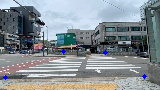

---------------------------------------------------------------
real : [47, 65, 72, 16, 47, 89, 66, 142]
e2e :  tensor([[ 49.2937,  63.1603,  68.7564,  16.1379,  48.0557,  90.3688,  65.0569,
         141.9734]], grad_fn=<AddmmBackward>)
[49.29368591308594, 63.16032791137695, 68.75635528564453, 16.13792610168457, 48.0556526184082, 90.36883544921875, 65.0568618774414, 141.97341918945312]


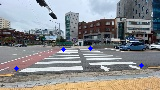

---------------------------------------------------------------
real : [44, 62, 71, 5, 45, 90, 68, 149]
e2e :  tensor([[ 46.3434,  58.0187,  69.5974,   8.3295,  46.0894,  93.4890,  66.4653,
         149.5311]], grad_fn=<AddmmBackward>)
[46.34343719482422, 58.01871109008789, 69.59744262695312, 8.329488754272461, 46.08942794799805, 93.48897552490234, 66.46527099609375, 149.5311279296875]


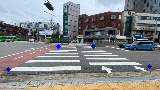

---------------------------------------------------------------
real : [45, 59, 74, 6, 45, 87, 67, 149]
e2e :  tensor([[ 46.8323,  55.0568,  69.4340,   7.5333,  46.3871,  90.6866,  66.0918,
         148.5467]], grad_fn=<AddmmBackward>)
[46.832305908203125, 55.056819915771484, 69.43396759033203, 7.533313274383545, 46.387088775634766, 90.68656158447266, 66.0918197631836, 148.54669189453125]


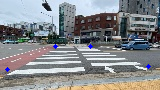

---------------------------------------------------------------
real : [53, 63, 73, 21, 51, 101, 73, 139]
e2e :  tensor([[ 53.6477,  66.7745,  73.8469,  15.1882,  52.5947,  97.4022,  71.3893,
         139.4979]], grad_fn=<AddmmBackward>)
[53.64769744873047, 66.77448272705078, 73.84693908691406, 15.188206672668457, 52.5947151184082, 97.40220642089844, 71.3893051147461, 139.4979248046875]


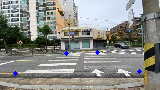

---------------------------------------------------------------
real : [49, 60, 73, 11, 48, 106, 73, 149]
e2e :  tensor([[ 48.7353,  62.5999,  73.7996,   6.8245,  48.9964, 102.0956,  72.0164,
         149.0469]], grad_fn=<AddmmBackward>)
[48.73527526855469, 62.599910736083984, 73.79962158203125, 6.824460029602051, 48.996395111083984, 102.09555053710938, 72.0163803100586, 149.04685974121094]


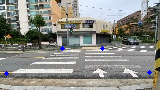

---------------------------------------------------------------
real : [47, 60, 69, 10, 47, 106, 71, 149]
e2e :  tensor([[ 46.5137,  62.7108,  72.3778,   6.0625,  47.0836, 102.5875,  70.7210,
         149.5429]], grad_fn=<AddmmBackward>)
[46.51373291015625, 62.71079635620117, 72.37776947021484, 6.062534809112549, 47.08363723754883, 102.58747100830078, 70.72100067138672, 149.5429229736328]


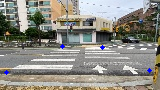

---------------------------------------------------------------
real : [44, 66, 73, 20, 42, 108, 71, 149]
e2e :  tensor([[ 45.6658,  71.0174,  70.6135,  12.8015,  45.9961, 104.5712,  68.5148,
         149.6541]], grad_fn=<AddmmBackward>)
[45.66584777832031, 71.01736450195312, 70.61353302001953, 12.80152702331543, 45.996097564697266, 104.57121276855469, 68.51475524902344, 149.65411376953125]


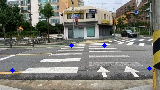

---------------------------------------------------------------
real : [32, 64, 63, 10, 30, 113, 66, 158]
e2e :  tensor([[ 31.6753,  68.2291,  63.6010,   3.4821,  34.3292, 109.4591,  62.4806,
         158.4642]], grad_fn=<AddmmBackward>)
[31.67534065246582, 68.22905731201172, 63.60099792480469, 3.4820501804351807, 34.329166412353516, 109.45907592773438, 62.48059844970703, 158.4642333984375]


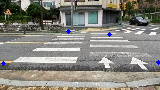

---------------------------------------------------------------
real : [35, 54, 61, 22, 35, 95, 64, 127]
e2e :  tensor([[ 34.1490,  55.2621,  63.5578,  20.2616,  35.7956,  94.8276,  62.8093,
         127.1157]], grad_fn=<AddmmBackward>)
[34.148956298828125, 55.26212692260742, 63.5577507019043, 20.261634826660156, 35.79557800292969, 94.82763671875, 62.80925750732422, 127.11572265625]


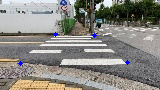

---------------------------------------------------------------
real : [52, 60, 74, 32, 51, 98, 77, 129]
e2e :  tensor([[ 51.5497,  60.3273,  76.8193,  31.0457,  51.0344,  97.3826,  75.1245,
         128.6624]], grad_fn=<AddmmBackward>)
[51.54972839355469, 60.327266693115234, 76.81932067871094, 31.04569435119629, 51.03435134887695, 97.38264465332031, 75.12451934814453, 128.6624298095703]


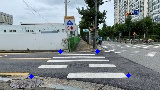

---------------------------------------------------------------
real : [45, 55, 74, 21, 44, 97, 78, 142]
e2e :  tensor([[ 45.7140,  53.5897,  75.3931,  21.0004,  46.3737,  98.9951,  73.7697,
         141.2209]], grad_fn=<AddmmBackward>)
[45.71400451660156, 53.58974075317383, 75.39314270019531, 21.00040054321289, 46.37374496459961, 98.99505615234375, 73.76972198486328, 141.2208709716797]


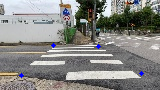

---------------------------------------------------------------
real : [37, 56, 64, 21, 37, 98, 69, 141]
e2e :  tensor([[ 35.5968,  53.9881,  67.1157,  20.9859,  37.1991,  97.1615,  65.5416,
         139.7496]], grad_fn=<AddmmBackward>)
[35.59675598144531, 53.98807907104492, 67.11572265625, 20.985916137695312, 37.1991081237793, 97.1615219116211, 65.54156494140625, 139.74957275390625]


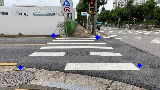

---------------------------------------------------------------
real : [47, 48, 83, 13, 46, 92, 86, 125]
e2e :  tensor([[ 49.3587,  43.8385,  79.1996,  14.2040,  50.3778,  97.7417,  79.7612,
         125.0664]], grad_fn=<AddmmBackward>)
[49.35865783691406, 43.83845138549805, 79.19955444335938, 14.20395278930664, 50.37778091430664, 97.74166870117188, 79.76119232177734, 125.0663833618164]


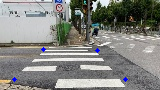

---------------------------------------------------------------
real : [39, 63, 63, 45, 39, 97, 63, 119]
e2e :  tensor([[ 36.6265,  64.0606,  65.8937,  45.8146,  37.4017,  95.9844,  64.5020,
         117.6480]], grad_fn=<AddmmBackward>)
[36.626548767089844, 64.06058502197266, 65.8936767578125, 45.81459426879883, 37.40174102783203, 95.98443603515625, 64.50202178955078, 117.6479721069336]


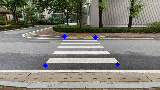

---------------------------------------------------------------
real : [53, 63, 78, 45, 53, 98, 79, 121]
e2e :  tensor([[ 53.4964,  62.6542,  79.2586,  44.4304,  52.6208,  97.9827,  77.6002,
         121.1361]], grad_fn=<AddmmBackward>)
[53.49635314941406, 62.6541862487793, 79.25859832763672, 44.43037033081055, 52.62077713012695, 97.98270416259766, 77.60021209716797, 121.1361312866211]


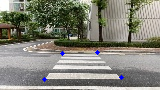

---------------------------------------------------------------
real : [45, 66, 69, 49, 45, 100, 69, 124]
e2e :  tensor([[ 43.4728,  67.0636,  72.0923,  49.8041,  43.5428,  99.2429,  70.2951,
         122.2293]], grad_fn=<AddmmBackward>)
[43.47279357910156, 67.0635986328125, 72.09234619140625, 49.80412673950195, 43.542789459228516, 99.24288940429688, 70.29512786865234, 122.22926330566406]


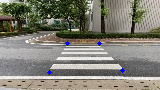

---------------------------------------------------------------
real : [30, 59, 63, 39, 31, 92, 63, 114]
e2e :  tensor([[ 30.9838,  57.9090,  61.9857,  39.0628,  32.6918,  93.9346,  61.5313,
         112.8167]], grad_fn=<AddmmBackward>)
[30.983766555786133, 57.908958435058594, 61.9857063293457, 39.06284713745117, 32.6917839050293, 93.93464660644531, 61.531333923339844, 112.8167495727539]


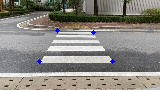

---------------------------------------------------------------
real : [43, 63, 74, 45, 43, 97, 74, 119]
e2e :  tensor([[ 44.0908,  62.4123,  73.2169,  44.9752,  44.4568,  98.9194,  72.2632,
         118.0708]], grad_fn=<AddmmBackward>)
[44.09075164794922, 62.41233444213867, 73.21686553955078, 44.975196838378906, 44.45683670043945, 98.91943359375, 72.26315307617188, 118.07077026367188]


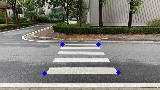

---------------------------------------------------------------
real : [71, 58, 88, 13, 70, 109, 88, 157]
e2e :  tensor([[ 70.7302,  60.1030,  92.2274,   8.0771,  68.7700, 104.7830,  89.6030,
         157.6598]], grad_fn=<AddmmBackward>)
[70.73020935058594, 60.10300827026367, 92.2274169921875, 8.077079772949219, 68.77003479003906, 104.78302001953125, 89.60301971435547, 157.65975952148438]


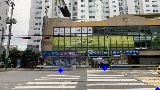

---------------------------------------------------------------
real : [72, 59, 89, 12, 71, 111, 87, 149]
e2e :  tensor([[ 71.0212,  63.1636,  91.5512,   9.6690,  69.1252, 105.9015,  89.8123,
         148.1206]], grad_fn=<AddmmBackward>)
[71.02117156982422, 63.163631439208984, 91.55123901367188, 9.669042587280273, 69.12521362304688, 105.90145874023438, 89.81232452392578, 148.12062072753906]


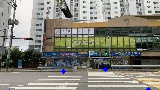

---------------------------------------------------------------
real : [72, 59, 88, 12, 71, 111, 86, 148]
e2e :  tensor([[ 70.0008,  60.7126,  90.7846,   8.1790,  68.1885, 104.3550,  88.9439,
         148.7577]], grad_fn=<AddmmBackward>)
[70.00076293945312, 60.712642669677734, 90.78455352783203, 8.17900276184082, 68.18850708007812, 104.35496520996094, 88.94389343261719, 148.7576904296875]


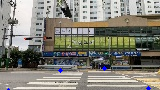

---------------------------------------------------------------
real : [71, 58, 88, 12, 71, 110, 86, 147]
e2e :  tensor([[ 69.9604,  62.0210,  90.7459,   9.0173,  68.1381, 105.0194,  88.8698,
         149.1574]], grad_fn=<AddmmBackward>)
[69.96035766601562, 62.02096176147461, 90.74594116210938, 9.017252922058105, 68.13810729980469, 105.01935577392578, 88.86983489990234, 149.15737915039062]


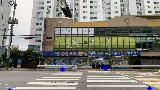

---------------------------------------------------------------
real : [77, 53, 89, 4, 77, 108, 88, 153]
e2e :  tensor([[ 74.2557,  56.4843,  94.4122,   6.8835,  71.8822, 102.3024,  91.8751,
         154.0700]], grad_fn=<AddmmBackward>)
[74.25566101074219, 56.48427200317383, 94.41224670410156, 6.8834710121154785, 71.88224792480469, 102.30244445800781, 91.8751220703125, 154.07003784179688]


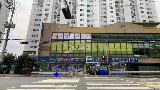

---------------------------------------------------------------
real : [78, 54, 89, 13, 77, 109, 88, 154]
e2e :  tensor([[ 75.3599,  56.3256,  95.4035,   6.5355,  72.9472, 102.7896,  93.0420,
         153.1686]], grad_fn=<AddmmBackward>)
[75.35986328125, 56.3255729675293, 95.40345001220703, 6.535481929779053, 72.94715881347656, 102.78960418701172, 93.04196166992188, 153.1685791015625]


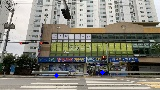

---------------------------------------------------------------
real : [66, 50, 84, 1, 64, 103, 87, 159]
e2e :  tensor([[ 63.6295,  50.2456,  87.8212,  -0.8027,  62.7344, 101.0956,  85.7176,
         157.6388]], grad_fn=<AddmmBackward>)
[63.629486083984375, 50.2456169128418, 87.82122802734375, -0.8026806712150574, 62.734432220458984, 101.09555053710938, 85.71756744384766, 157.63882446289062]


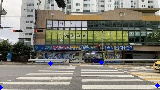

---------------------------------------------------------------
real : [66, 50, 84, 1, 65, 104, 88, 159]
e2e :  tensor([[ 65.6877,  50.8065,  89.3004,   0.5619,  64.4465, 100.9490,  86.7763,
         160.0880]], grad_fn=<AddmmBackward>)
[65.687744140625, 50.80649185180664, 89.30043029785156, 0.5619023442268372, 64.44654846191406, 100.94898223876953, 86.77629089355469, 160.08798217773438]


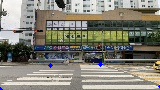

---------------------------------------------------------------
real : [65, 73, 84, 11, 62, 129, 87, 141]
e2e :  tensor([[ 61.6319,  76.9021,  88.0701,   7.5421,  62.2086, 123.0823,  89.6400,
         141.4338]], grad_fn=<AddmmBackward>)
[61.63189697265625, 76.90213775634766, 88.07012176513672, 7.542140483856201, 62.208560943603516, 123.08234405517578, 89.64000701904297, 141.4337615966797]


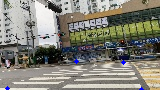

---------------------------------------------------------------
real : [67, 64, 85, 6, 65, 118, 88, 150]
e2e :  tensor([[ 64.1290,  65.6222,  89.4092,   4.3799,  63.8812, 114.0110,  89.2035,
         150.3416]], grad_fn=<AddmmBackward>)
[64.12902069091797, 65.62224578857422, 89.40924835205078, 4.379886150360107, 63.88124465942383, 114.01100158691406, 89.20350646972656, 150.34164428710938]


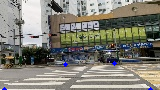

---------------------------------------------------------------
real : [67, 50, 88, 4, 66, 105, 85, 159]
e2e :  tensor([[ 67.1310,  52.1927,  90.1358,   2.1472,  65.6486, 101.1825,  87.4486,
         160.1990]], grad_fn=<AddmmBackward>)
[67.13095092773438, 52.192684173583984, 90.13578796386719, 2.1471807956695557, 65.64862823486328, 101.18253326416016, 87.4486083984375, 160.19903564453125]


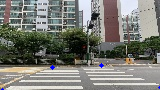

---------------------------------------------------------------
real : [68, 50, 89, 5, 67, 105, 85, 159]
e2e :  tensor([[ 66.5906,  51.7267,  89.4642,   2.0482,  65.1273, 100.4268,  86.7952,
         159.0990]], grad_fn=<AddmmBackward>)
[66.59063720703125, 51.72671127319336, 89.46420288085938, 2.0482161045074463, 65.12725830078125, 100.42682647705078, 86.79521179199219, 159.09902954101562]


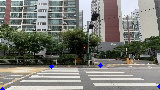

---------------------------------------------------------------
real : [67, 54, 87, 0, 66, 110, 84, 156]
e2e :  tensor([[ 6.4245e+01,  5.4737e+01,  8.9252e+01, -7.7588e-02,  6.3626e+01,
          1.0616e+02,  8.7827e+01,  1.5687e+02]], grad_fn=<AddmmBackward>)
[64.24472045898438, 54.73684310913086, 89.25231170654297, -0.07758776843547821, 63.625797271728516, 106.15534973144531, 87.82709503173828, 156.86761474609375]


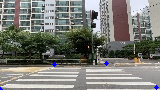

---------------------------------------------------------------
real : [67, 55, 87, 1, 66, 111, 85, 158]
e2e :  tensor([[ 63.9987,  55.9797,  90.1072,  -0.7383,  63.6137, 108.8645,  88.8226,
         160.0420]], grad_fn=<AddmmBackward>)
[63.99867248535156, 55.979740142822266, 90.10722351074219, -0.738297164440155, 63.61372756958008, 108.8645248413086, 88.82258605957031, 160.04202270507812]


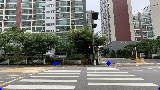

---------------------------------------------------------------
real : [66, 53, 85, 1, 65, 110, 86, 159]
e2e :  tensor([[6.4880e+01, 5.3813e+01, 8.9470e+01, 1.4051e-01, 6.4081e+01, 1.0492e+02,
         8.7786e+01, 1.5750e+02]], grad_fn=<AddmmBackward>)
[64.88045501708984, 53.812747955322266, 89.46981811523438, 0.14051182568073273, 64.08141326904297, 104.92285919189453, 87.78614807128906, 157.50161743164062]


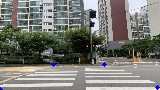

---------------------------------------------------------------
real : [66, 67, 86, 3, 65, 123, 88, 155]
e2e :  tensor([[ 62.6551,  68.0759,  90.3286,   2.4757,  63.0582, 119.6089,  90.7197,
         154.3896]], grad_fn=<AddmmBackward>)
[62.65509796142578, 68.07586669921875, 90.3285903930664, 2.475700616836548, 63.05824661254883, 119.60887908935547, 90.7197036743164, 154.38955688476562]


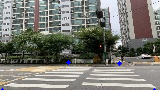

---------------------------------------------------------------
real : [66, 67, 86, 3, 66, 124, 86, 156]
e2e :  tensor([[ 62.9757,  68.5451,  90.7538,   2.8345,  63.3302, 120.0422,  90.9869,
         156.2395]], grad_fn=<AddmmBackward>)
[62.97572326660156, 68.54507446289062, 90.75382995605469, 2.8345062732696533, 63.330196380615234, 120.04216766357422, 90.98687744140625, 156.23951721191406]


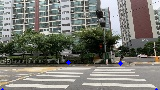

---------------------------------------------------------------
real : [65, 65, 84, 1, 66, 122, 88, 154]
e2e :  tensor([[ 62.5932,  64.1750,  90.0582,   0.9150,  62.8707, 116.6178,  90.0800,
         155.7334]], grad_fn=<AddmmBackward>)
[62.59321594238281, 64.17503356933594, 90.05817413330078, 0.9149678349494934, 62.870731353759766, 116.6178207397461, 90.08001708984375, 155.7333984375]


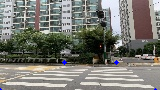

---------------------------------------------------------------
real : [66, 59, 89, 0, 65, 106, 86, 159]
e2e :  tensor([[ 65.0891,  56.3448,  89.7154,   1.8777,  64.2224, 106.2727,  87.8365,
         159.5385]], grad_fn=<AddmmBackward>)
[65.08909606933594, 56.34476089477539, 89.71537780761719, 1.8777164220809937, 64.22235107421875, 106.2727279663086, 87.83649444580078, 159.53848266601562]


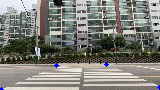

---------------------------------------------------------------
real : [69, 73, 87, 10, 70, 121, 89, 155]
e2e :  tensor([[ 67.4143,  73.0745,  92.0997,   9.9672,  66.6833, 118.1176,  91.3279,
         155.5802]], grad_fn=<AddmmBackward>)
[67.41425323486328, 73.07450866699219, 92.0997085571289, 9.967185020446777, 66.683349609375, 118.11760711669922, 91.32792663574219, 155.58023071289062]


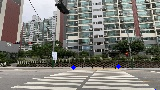

---------------------------------------------------------------
real : [64, 47, 88, 5, 65, 91, 87, 156]
e2e :  tensor([[ 67.3551,  46.1986,  87.4679,   3.2857,  65.0996,  91.5512,  83.7303,
         156.1488]], grad_fn=<AddmmBackward>)
[67.35507202148438, 46.19855880737305, 87.46791076660156, 3.285749673843384, 65.09955596923828, 91.55121612548828, 83.73027038574219, 156.1488037109375]


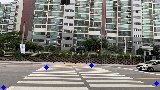

---------------------------------------------------------------
real : [70, 63, 88, 0, 67, 111, 87, 152]
e2e :  tensor([[ 66.5661,  60.5695,  90.7971,   3.2883,  65.8007, 109.7726,  89.8783,
         152.6877]], grad_fn=<AddmmBackward>)
[66.56612396240234, 60.56953811645508, 90.7970962524414, 3.2883198261260986, 65.8006591796875, 109.77259063720703, 89.8782958984375, 152.68768310546875]


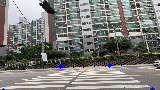

---------------------------------------------------------------
real : [61, 64, 80, 1, 60, 110, 89, 158]
e2e :  tensor([[ 59.8738,  61.5680,  86.5137,   2.0137,  59.9168, 111.1284,  85.5484,
         157.3729]], grad_fn=<AddmmBackward>)
[59.87376403808594, 61.567989349365234, 86.51374816894531, 2.0137388706207275, 59.916812896728516, 111.1283950805664, 85.54837036132812, 157.37294006347656]


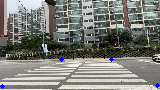

---------------------------------------------------------------
real : [69, 65, 89, 11, 68, 109, 88, 149]
e2e :  tensor([[ 68.9137,  64.9807,  90.2513,  10.0692,  67.2857, 107.2826,  88.5283,
         149.7518]], grad_fn=<AddmmBackward>)
[68.9137191772461, 64.98068237304688, 90.25131225585938, 10.06921672821045, 67.28569793701172, 107.28255462646484, 88.52826690673828, 149.75180053710938]


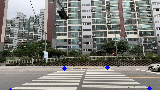

---------------------------------------------------------------
real : [75, 47, 89, 27, 75, 95, 89, 138]
e2e :  tensor([[ 74.2746,  49.0194,  93.5809,  25.3104,  71.0440,  91.5084,  90.3088,
         137.4399]], grad_fn=<AddmmBackward>)
[74.27464294433594, 49.01935958862305, 93.58092498779297, 25.310354232788086, 71.04402160644531, 91.50838470458984, 90.30875396728516, 137.43988037109375]


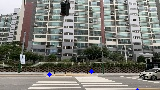

---------------------------------------------------------------
real : [58, 50, 82, 0, 58, 95, 84, 127]
e2e :  tensor([[ 59.5964,  49.0226,  80.9599,  -1.2236,  59.1311,  95.8169,  81.1190,
         127.1665]], grad_fn=<AddmmBackward>)
[59.59637451171875, 49.02262496948242, 80.95987701416016, -1.223610520362854, 59.131107330322266, 95.81693267822266, 81.11896514892578, 127.16649627685547]


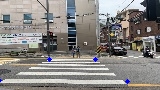

---------------------------------------------------------------
real : [54, 56, 83, 18, 53, 99, 81, 131]
e2e :  tensor([[ 54.3334,  54.5216,  80.5852,  18.0060,  54.2919, 100.0250,  80.0000,
         131.2872]], grad_fn=<AddmmBackward>)
[54.33341979980469, 54.52156448364258, 80.58517456054688, 18.00604248046875, 54.2918815612793, 100.02501678466797, 79.99996948242188, 131.28720092773438]


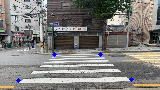

---------------------------------------------------------------
real : [47, 83, 66, 26, 47, 130, 77, 137]
e2e :  tensor([[ 45.8931,  90.4021,  72.6971,  17.9549,  47.3157, 122.2188,  73.5988,
         137.5929]], grad_fn=<AddmmBackward>)
[45.89314270019531, 90.40213012695312, 72.69711303710938, 17.954933166503906, 47.315738677978516, 122.21875, 73.59880828857422, 137.59286499023438]


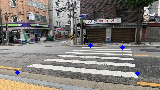

---------------------------------------------------------------
real : [47, 81, 67, 23, 48, 127, 78, 134]
e2e :  tensor([[ 46.2959,  87.8614,  73.1524,  15.6835,  47.8317, 121.6308,  74.4972,
         134.5553]], grad_fn=<AddmmBackward>)
[46.29585266113281, 87.86135864257812, 73.15238952636719, 15.6834716796875, 47.8316535949707, 121.6307601928711, 74.4971923828125, 134.5552978515625]


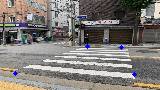

---------------------------------------------------------------
real : [48, 49, 80, 2, 49, 97, 79, 153]
e2e :  tensor([[ 51.7895,  50.0714,  77.5725,  -1.5447,  51.9475,  97.8388,  75.5951,
         153.9210]], grad_fn=<AddmmBackward>)
[51.789459228515625, 50.07138442993164, 77.5724868774414, -1.544655442237854, 51.94749069213867, 97.8388442993164, 75.59513854980469, 153.9209747314453]


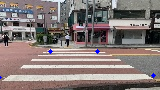

---------------------------------------------------------------
real : [55, 53, 87, 8, 56, 100, 88, 155]
e2e :  tensor([[ 60.2103,  54.5628,  83.9850,   2.9300,  59.3973, 100.7076,  81.6765,
         155.5095]], grad_fn=<AddmmBackward>)
[60.21025085449219, 54.56276321411133, 83.98504638671875, 2.930044412612915, 59.397281646728516, 100.70755004882812, 81.67645263671875, 155.5094757080078]


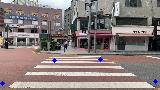

---------------------------------------------------------------
real : [54, 68, 78, 4, 55, 114, 86, 128]
e2e :  tensor([[ 53.9572,  67.0932,  80.7077,   3.5850,  55.2735, 114.6713,  83.1475,
         127.0308]], grad_fn=<AddmmBackward>)
[53.957244873046875, 67.09315490722656, 80.70770263671875, 3.5849974155426025, 55.273494720458984, 114.67131805419922, 83.14753723144531, 127.03075408935547]


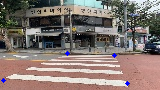

---------------------------------------------------------------
real : [57, 59, 79, 6, 57, 107, 81, 155]
e2e :  tensor([[ 56.8773,  59.6747,  82.1256,   3.9435,  56.6588, 105.0715,  80.3516,
         155.4229]], grad_fn=<AddmmBackward>)
[56.877288818359375, 59.674747467041016, 82.12559509277344, 3.943499803543091, 56.65876388549805, 105.0715103149414, 80.35163879394531, 155.42288208007812]


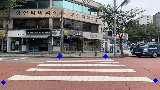

---------------------------------------------------------------
real : [44, 9, 88, 52, 39, 65, 56, 157]
e2e :  tensor([[ 42.2124,   9.8730,  76.7111,  52.8761,  40.6957,  62.7888,  68.1207,
         157.1259]], grad_fn=<AddmmBackward>)
[42.212425231933594, 9.872953414916992, 76.71110534667969, 52.87606430053711, 40.695701599121094, 62.78881072998047, 68.12068939208984, 157.12594604492188]


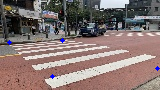

---------------------------------------------------------------
real : [51, 58, 72, 79, 49, 77, 66, 140]
e2e :  tensor([[ 53.1302,  60.6625,  73.2200,  74.1177,  48.9119,  75.0529,  64.1258,
         141.2329]], grad_fn=<AddmmBackward>)
[53.13019561767578, 60.66245651245117, 73.22004699707031, 74.11769104003906, 48.91194152832031, 75.0528793334961, 64.12581634521484, 141.23294067382812]


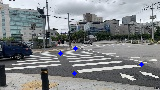

---------------------------------------------------------------
real : [41, 80, 66, 47, 40, 102, 65, 131]
e2e :  tensor([[ 40.8154,  79.3175,  66.5189,  46.1380,  40.7011, 101.6140,  63.8530,
         130.3854]], grad_fn=<AddmmBackward>)
[40.81544494628906, 79.31745147705078, 66.51893615722656, 46.137962341308594, 40.701053619384766, 101.61396789550781, 63.852989196777344, 130.3853759765625]


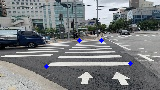

---------------------------------------------------------------
real : [53, 59, 64, 5, 52, 104, 74, 99]
e2e :  tensor([[50.0111, 60.9896, 70.8143,  3.5541, 50.8280, 99.6576, 73.7828, 98.9242]],
       grad_fn=<AddmmBackward>)
[50.01109313964844, 60.989566802978516, 70.81429290771484, 3.554060220718384, 50.82802963256836, 99.65760803222656, 73.78284454345703, 98.92424011230469]


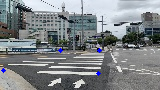

---------------------------------------------------------------
real : [46, 59, 82, 9, 47, 80, 81, 96]
e2e :  tensor([[54.6141, 53.6763, 70.5689,  6.8781, 53.8115, 87.0334, 71.6064, 96.8864]],
       grad_fn=<AddmmBackward>)
[54.61412048339844, 53.67631149291992, 70.56887817382812, 6.878111362457275, 53.811466217041016, 87.03336334228516, 71.60636138916016, 96.88643646240234]


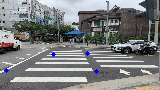

---------------------------------------------------------------
real : [46, 48, 86, 3, 46, 69, 80, 96]
e2e :  tensor([[55.4817, 42.3411, 70.6260,  1.7486, 54.3497, 79.0782, 71.0750, 97.2708]],
       grad_fn=<AddmmBackward>)
[55.48167419433594, 42.341121673583984, 70.62596130371094, 1.748623251914978, 54.34970474243164, 79.07820129394531, 71.07501983642578, 97.27079010009766]


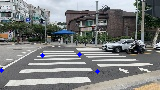

---------------------------------------------------------------
real : [56, 80, 77, 77, 56, 102, 74, 156]
e2e :  tensor([[ 55.3868,  80.8364,  81.6419,  77.0269,  52.5466, 100.6799,  74.5862,
         153.5323]], grad_fn=<AddmmBackward>)
[55.38676452636719, 80.83641815185547, 81.64187622070312, 77.0268783569336, 52.54661178588867, 100.67987060546875, 74.5862045288086, 153.5323486328125]


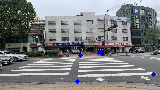

---------------------------------------------------------------
real : [40, 63, 66, 23, 40, 88, 65, 144]
e2e :  tensor([[ 41.4287,  61.0831,  65.2722,  23.1273,  41.0626,  90.3419,  61.3759,
         143.8651]], grad_fn=<AddmmBackward>)
[41.4287109375, 61.08314895629883, 65.27222442626953, 23.127349853515625, 41.062618255615234, 90.34185791015625, 61.375946044921875, 143.86509704589844]


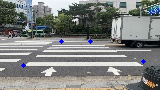

---------------------------------------------------------------
real : [56, 55, 79, 1, 56, 102, 75, 159]
e2e :  tensor([[ 55.1489,  54.4123,  80.4608,   2.0412,  54.8445, 100.4803,  77.9109,
         159.3434]], grad_fn=<AddmmBackward>)
[55.14894104003906, 54.4123420715332, 80.46083068847656, 2.0411598682403564, 54.84453201293945, 100.48031616210938, 77.91093444824219, 159.34344482421875]


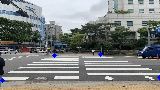

---------------------------------------------------------------
real : [56, 28, 78, 7, 54, 54, 70, 87]
e2e :  tensor([[61.1967, 26.7069, 68.7843,  3.6119, 57.8247, 57.0456, 66.8705, 87.7639]],
       grad_fn=<AddmmBackward>)
[61.19670104980469, 26.706884384155273, 68.7843017578125, 3.6119158267974854, 57.82473373413086, 57.04562759399414, 66.87049102783203, 87.76386260986328]


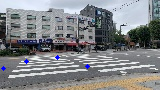

---------------------------------------------------------------
real : [48, 68, 79, 14, 48, 95, 78, 135]
e2e :  tensor([[ 52.4936,  65.3038,  73.7064,  11.9103,  51.9539,  98.9226,  72.2066,
         135.3732]], grad_fn=<AddmmBackward>)
[52.493621826171875, 65.3038330078125, 73.70637512207031, 11.910321235656738, 51.95389938354492, 98.92256927490234, 72.2066421508789, 135.37319946289062]


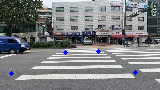

---------------------------------------------------------------
real : [45, 71, 78, 2, 46, 91, 80, 93]
e2e :  tensor([[50.5031, 62.9772, 70.4058,  5.1697, 51.2373, 99.8032, 73.7353, 93.4676]],
       grad_fn=<AddmmBackward>)
[50.5030517578125, 62.97724533081055, 70.40579986572266, 5.169697284698486, 51.23726272583008, 99.80317687988281, 73.73529052734375, 93.46759796142578]


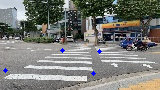

---------------------------------------------------------------
real : [46, 92, 69, 72, 45, 110, 69, 149]
e2e :  tensor([[ 45.8803,  93.3047,  72.7008,  69.8250,  44.5015, 108.1672,  67.3198,
         148.7617]], grad_fn=<AddmmBackward>)
[45.880271911621094, 93.3047103881836, 72.70079040527344, 69.82500457763672, 44.50149917602539, 108.16724395751953, 67.31976318359375, 148.76171875]


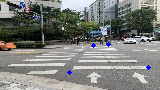

---------------------------------------------------------------
real : [57, 42, 82, 45, 55, 66, 75, 113]
e2e :  tensor([[ 60.2956,  39.2182,  77.5098,  44.5852,  56.7161,  69.3114,  72.6758,
         112.8785]], grad_fn=<AddmmBackward>)
[60.29558563232422, 39.21821212768555, 77.50980377197266, 44.585227966308594, 56.71608352661133, 69.31136322021484, 72.67584991455078, 112.87847137451172]


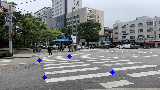

---------------------------------------------------------------
real : [49, 77, 72, 56, 49, 99, 72, 131]
e2e :  tensor([[ 49.1026,  75.9012,  74.0821,  56.0359,  47.8384,  99.5434,  70.5734,
         130.2920]], grad_fn=<AddmmBackward>)
[49.10261535644531, 75.90123748779297, 74.0821304321289, 56.03591537475586, 47.83839797973633, 99.54338836669922, 70.57339477539062, 130.29196166992188]


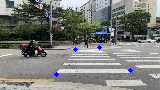

---------------------------------------------------------------
real : [59, 74, 80, 62, 58, 96, 78, 125]
e2e :  tensor([[ 59.9936,  73.5644,  80.8824,  60.6207,  57.1858,  95.6092,  76.9090,
         124.1823]], grad_fn=<AddmmBackward>)
[59.99360656738281, 73.56439971923828, 80.88243103027344, 60.62065505981445, 57.185829162597656, 95.60917663574219, 76.90902709960938, 124.18231201171875]


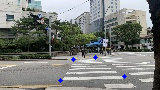

---------------------------------------------------------------
real : [46, 75, 77, 8, 45, 92, 60, 149]
e2e :  tensor([[ 45.0052,  67.9802,  67.3916,  15.9918,  44.5605,  96.2742,  63.8648,
         149.3267]], grad_fn=<AddmmBackward>)
[45.00518035888672, 67.98017883300781, 67.3916015625, 15.991753578186035, 44.56046676635742, 96.2741928100586, 63.864776611328125, 149.32666015625]


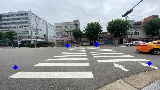

---------------------------------------------------------------
real : [45, 79, 75, 13, 45, 94, 60, 30]
e2e :  tensor([[46.6968, 75.3658, 59.3234, 15.2562, 47.5829, 96.1842, 66.6935, 34.9050]],
       grad_fn=<AddmmBackward>)
[46.69684600830078, 75.36578369140625, 59.3233528137207, 15.256237983703613, 47.58285903930664, 96.18421936035156, 66.69347381591797, 34.90495681762695]


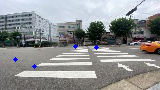

---------------------------------------------------------------
real : [46, 81, 73, 19, 45, 98, 61, 159]
e2e :  tensor([[ 46.2958,  75.7689,  68.8562,  21.6062,  45.5321, 100.5491,  64.4469,
         158.3598]], grad_fn=<AddmmBackward>)
[46.2957763671875, 75.76885986328125, 68.85620880126953, 21.606151580810547, 45.53212356567383, 100.54905700683594, 64.44693756103516, 158.3597869873047]


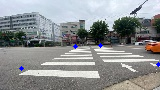

---------------------------------------------------------------
real : [45, 77, 75, 11, 45, 94, 45, 94]
e2e :  tensor([[46.2575, 70.1745, 63.9367, 14.9207, 46.4004, 95.5821, 65.5610, 95.0550]],
       grad_fn=<AddmmBackward>)
[46.257469177246094, 70.17451477050781, 63.93669891357422, 14.920682907104492, 46.4003791809082, 95.5820541381836, 65.56095123291016, 95.0550308227539]


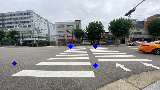

---------------------------------------------------------------
real : [45, 75, 75, 8, 45, 92, 60, 148]
e2e :  tensor([[ 44.1917,  67.7640,  67.0322,  15.2836,  43.9056,  96.6792,  63.6171,
         149.6187]], grad_fn=<AddmmBackward>)
[44.191680908203125, 67.76402282714844, 67.03219604492188, 15.283609390258789, 43.90559768676758, 96.67919158935547, 63.617149353027344, 149.6186981201172]


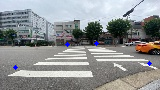

---------------------------------------------------------------
real : [46, 76, 73, 11, 46, 92, 64, 145]
e2e :  tensor([[ 46.0527,  67.5085,  67.8332,  15.6609,  45.5596,  95.9472,  64.7235,
         144.6978]], grad_fn=<AddmmBackward>)
[46.05266571044922, 67.50851440429688, 67.83323669433594, 15.660930633544922, 45.55960464477539, 95.94722747802734, 64.72350311279297, 144.69778442382812]


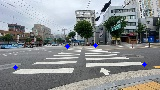

---------------------------------------------------------------
real : [46, 73, 73, 7, 45, 89, 64, 142]
e2e :  tensor([[ 46.4825,  65.2802,  69.2926,  12.2925,  46.2982,  97.4621,  66.7573,
         144.5133]], grad_fn=<AddmmBackward>)
[46.48252868652344, 65.28020477294922, 69.29258728027344, 12.292475700378418, 46.29823684692383, 97.46205139160156, 66.75730895996094, 144.51329040527344]


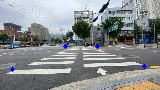

---------------------------------------------------------------
real : [47, 71, 75, 1, 46, 87, 64, 138]
e2e :  tensor([[ 46.2751,  60.3342,  67.3442,  10.8185,  45.9198,  91.8525,  65.1355,
         134.6808]], grad_fn=<AddmmBackward>)
[46.27513885498047, 60.334224700927734, 67.34423828125, 10.818510055541992, 45.919803619384766, 91.85245513916016, 65.1355209350586, 134.6807861328125]


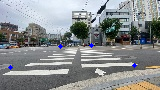

---------------------------------------------------------------
real : [46, 75, 72, 10, 46, 91, 66, 145]
e2e :  tensor([[ 47.4330,  67.8993,  69.5898,  15.1605,  46.9441,  97.6907,  66.5905,
         146.4239]], grad_fn=<AddmmBackward>)
[47.4329833984375, 67.89932250976562, 69.58981323242188, 15.160517692565918, 46.94413375854492, 97.6906509399414, 66.5904769897461, 146.42388916015625]


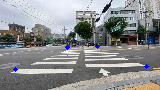

---------------------------------------------------------------
real : [46, 79, 71, 18, 46, 96, 66, 154]
e2e :  tensor([[ 47.8393,  74.9500,  69.2505,  21.8190,  46.8681,  99.1486,  65.1204,
         152.9776]], grad_fn=<AddmmBackward>)
[47.83929443359375, 74.94996643066406, 69.25051879882812, 21.819011688232422, 46.86806869506836, 99.1485595703125, 65.12035369873047, 152.97760009765625]


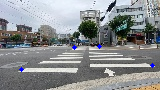

---------------------------------------------------------------
real : [48, 57, 71, 0, 49, 82, 63, 140]
e2e :  tensor([[ 48.0834,  50.1510,  69.0076,   5.7976,  47.3946,  86.0164,  66.0279,
         139.7967]], grad_fn=<AddmmBackward>)
[48.08342742919922, 50.15097427368164, 69.00761413574219, 5.797561168670654, 47.39462661743164, 86.01642608642578, 66.0278549194336, 139.79666137695312]


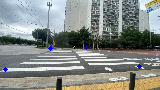

---------------------------------------------------------------
real : [48, 61, 69, 8, 48, 87, 63, 147]
e2e :  tensor([[ 48.1637,  57.7212,  69.1097,  11.4622,  47.2324,  89.3620,  65.3325,
         146.6930]], grad_fn=<AddmmBackward>)
[48.16368865966797, 57.72117233276367, 69.10972595214844, 11.462244033813477, 47.232418060302734, 89.36201477050781, 65.3324966430664, 146.69296264648438]


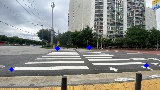

---------------------------------------------------------------
real : [48, 65, 68, 16, 48, 90, 64, 154]
e2e :  tensor([[ 48.4323,  63.8511,  68.8426,  17.4553,  47.0438,  90.5349,  63.8623,
         154.3572]], grad_fn=<AddmmBackward>)
[48.43229675292969, 63.85110092163086, 68.8426284790039, 17.45525550842285, 47.04375076293945, 90.5348892211914, 63.862327575683594, 154.35723876953125]


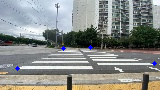

---------------------------------------------------------------
real : [48, 66, 68, 17, 47, 91, 64, 155]
e2e :  tensor([[ 47.5630,  63.0184,  68.1334,  16.7066,  46.2906,  90.0431,  63.2685,
         153.3747]], grad_fn=<AddmmBackward>)
[47.563011169433594, 63.01835250854492, 68.13336181640625, 16.70659828186035, 46.29056167602539, 90.04305267333984, 63.26850509643555, 153.37472534179688]


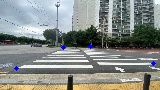

---------------------------------------------------------------
real : [48, 63, 68, 14, 48, 89, 64, 150]
e2e :  tensor([[ 47.8533,  61.0513,  68.5445,  14.8719,  46.6810,  89.7128,  64.0153,
         151.3686]], grad_fn=<AddmmBackward>)
[47.853302001953125, 61.05130386352539, 68.54450988769531, 14.871869087219238, 46.68100357055664, 89.71277618408203, 64.0152587890625, 151.36859130859375]


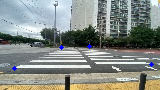

---------------------------------------------------------------
real : [44, 63, 69, 14, 43, 89, 58, 141]
e2e :  tensor([[ 44.7103,  61.8731,  65.5535,  14.3671,  43.9893,  89.7351,  61.8339,
         143.8142]], grad_fn=<AddmmBackward>)
[44.7103271484375, 61.87314224243164, 65.55352783203125, 14.367072105407715, 43.98928451538086, 89.73514556884766, 61.83392333984375, 143.81417846679688]


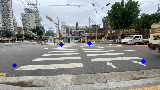

---------------------------------------------------------------
real : [44, 67, 67, 21, 43, 94, 59, 149]
e2e :  tensor([[ 44.4996,  68.4041,  65.3383,  19.3233,  43.5810,  92.4236,  60.9225,
         149.5241]], grad_fn=<AddmmBackward>)
[44.49957275390625, 68.40406799316406, 65.33828735351562, 19.323348999023438, 43.58102798461914, 92.4236068725586, 60.92245101928711, 149.52407836914062]


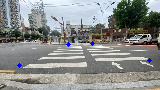

---------------------------------------------------------------
real : [44, 65, 69, 19, 44, 93, 58, 147]
e2e :  tensor([[ 44.2960,  65.0608,  64.7281,  17.3633,  43.4143,  90.0780,  60.6095,
         145.2286]], grad_fn=<AddmmBackward>)
[44.29595947265625, 65.06075286865234, 64.72805786132812, 17.36325454711914, 43.41432571411133, 90.07799530029297, 60.609500885009766, 145.2286376953125]


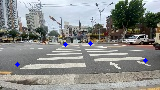

---------------------------------------------------------------
real : [50, 65, 74, 15, 50, 92, 68, 148]
e2e :  tensor([[ 51.4982,  62.9718,  72.2216,  14.4875,  50.3056,  93.6008,  68.4428,
         149.0156]], grad_fn=<AddmmBackward>)
[51.4981689453125, 62.97177505493164, 72.2215805053711, 14.48747444152832, 50.30557632446289, 93.60082244873047, 68.44281768798828, 149.0155792236328]


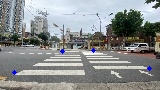

---------------------------------------------------------------
real : [49, 63, 75, 12, 50, 92, 67, 144]
e2e :  tensor([[ 50.7031,  61.2314,  71.1777,  13.1257,  49.6563,  92.3176,  67.8696,
         143.8248]], grad_fn=<AddmmBackward>)
[50.703094482421875, 61.231441497802734, 71.177734375, 13.125654220581055, 49.65634536743164, 92.31756591796875, 67.8696060180664, 143.82481384277344]


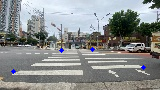

---------------------------------------------------------------
real : [53, 72, 70, 1, 51, 99, 69, 113]
e2e :  tensor([[ 49.2970,  65.1613,  70.8054,   7.6267,  49.8262, 101.0578,  72.2081,
         112.9999]], grad_fn=<AddmmBackward>)
[49.297019958496094, 65.16134643554688, 70.80538940429688, 7.626742839813232, 49.82622146606445, 101.05777740478516, 72.20807647705078, 112.99988555908203]


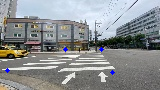

---------------------------------------------------------------
real : [53, 76, 68, 11, 52, 105, 68, 122]
e2e :  tensor([[ 50.2037,  73.1244,  71.3862,  14.3970,  50.2686, 103.9686,  71.5968,
         122.0992]], grad_fn=<AddmmBackward>)
[50.2037353515625, 73.1243667602539, 71.38619995117188, 14.397008895874023, 50.26862716674805, 103.96857452392578, 71.59683990478516, 122.09923553466797]


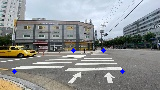

---------------------------------------------------------------
real : [53, 78, 67, 17, 52, 108, 70, 126]
e2e :  tensor([[ 50.1846,  77.0856,  71.4714,  17.0948,  50.1746, 105.9895,  71.3813,
         125.1720]], grad_fn=<AddmmBackward>)
[50.18464660644531, 77.08561706542969, 71.471435546875, 17.094764709472656, 50.174617767333984, 105.9894790649414, 71.38126373291016, 125.17195129394531]


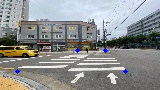

---------------------------------------------------------------
real : [53, 80, 67, 19, 53, 111, 71, 128]
e2e :  tensor([[ 50.3139,  79.0005,  71.6823,  18.4181,  50.2506, 107.0399,  71.3990,
         127.2268]], grad_fn=<AddmmBackward>)
[50.313934326171875, 79.00054168701172, 71.6822509765625, 18.41806983947754, 50.25058364868164, 107.0399398803711, 71.3990249633789, 127.22679901123047]


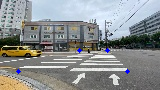

---------------------------------------------------------------
real : [53, 77, 67, 15, 53, 108, 70, 125]
e2e :  tensor([[ 50.3271,  76.8795,  72.1574,  15.9971,  50.4660, 107.2103,  72.3088,
         125.5822]], grad_fn=<AddmmBackward>)
[50.32708740234375, 76.8795166015625, 72.15741729736328, 15.997146606445312, 50.46596908569336, 107.21034240722656, 72.30883026123047, 125.58222961425781]


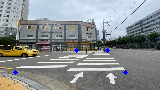

Finish


In [7]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import torch
import torch.nn as nn
import torch.optim as optim

import glob, csv, random, time, io, dill, os, cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt 
from google.colab.patches import cv2_imshow


def study_model_load(episode, batch_cnt, model, device):
    LoadPath_main = os.getcwd()+"/save/main_model_025000_000101.pth" #"+str(episode).zfill(6)+  str(batch_cnt).zfill(6)+ ".pth"
    #LoadPath_main = os.getcwd()+"/new_save/main_model_004100_000002.pth" #"+str(episode).zfill(6)+  str(batch_cnt).zfill(6)+ ".pth"
    with open(LoadPath_main, 'rb') as f:
        LoadBuffer = io.BytesIO(f.read())
    model.load_state_dict(torch.load(LoadBuffer, map_location=device))
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = train_model().to(device)
net = study_model_load(1100, 73, net, device)
net.eval()

cnt = 1

for ccss in yy:
    #name = "./new/new_8resized/"+str(ccss[0])+".jpg"
    name = "./8resized_pic/"+str(ccss[0])+".jpg"
    img = Image.open(name)

    image_cv = cv2.imread(name, cv2.IMREAD_UNCHANGED)
    
    
    img = img.convert('YCbCr')
    img = np.array(img)
    img = img.transpose((2, 0, 1)) / 255.0
    img = [img.tolist()]

    x = torch.FloatTensor(img).to(device)
    
    output_x = net(x)
    
    print("---------------------------------------------------------------")
    print("real :", ccss[1:])
    print("e2e : ", output_x )

    output_x_list = output_x.tolist()
    output_x_list = output_x_list[0]
    print(output_x_list)
      
    cv2.circle(image_cv,(int(output_x_list[1]), int(output_x_list[0])), 2, (255, 0, 0), thickness = -1)
    cv2.circle(image_cv, (int(output_x_list[3]), int(output_x_list[2])), 2, (255, 0, 0), thickness = -1)
    cv2.circle(image_cv, (int(output_x_list[5]), int(output_x_list[4])), 2, (255, 0, 0), thickness = -1)
    cv2.circle(image_cv, (int(output_x_list[7]), int(output_x_list[6])), 2, (255, 0, 0), thickness = -1)
    # cv2.circle(image_cv,(int(output_x_list[0]), int(output_x_list[1])), 2, (255, 0, 0), thickness = -1)
    # cv2.circle(image_cv, (int(output_x_list[2]), int(output_x_list[3])), 2, (255, 0, 0), thickness = -1)
    # cv2.circle(image_cv, (int(output_x_list[4]), int(output_x_list[5])), 2, (255, 0, 0), thickness = -1)
    # cv2.circle(image_cv, (int(output_x_list[6]), int(output_x_list[7])), 2, (255, 0, 0), thickness = -1)
    cv2_imshow(image_cv)
    
    cnt += 1


print("Finish")

- 실제 test 데이터로 2차 test

['1', '39', '63', '74', '23', '40', '105', '75', '143\n']
[1, 39, 63, 74, 23, 40, 105, 75, 143]
['2', '37', '65', '72', '31', '39', '102', '72', '139\n']
[2, 37, 65, 72, 31, 39, 102, 72, 139]
['3', '39', '60', '82', '6', '42', '100', '81', '152\n']
[3, 39, 60, 82, 6, 42, 100, 81, 152]
['4', '36', '56', '75', '13', '40', '99', '75', '145\n']
[4, 36, 56, 75, 13, 40, 99, 75, 145]
y2y [[1, 39, 63, 74, 23, 40, 105, 75, 143], [2, 37, 65, 72, 31, 39, 102, 72, 139], [3, 39, 60, 82, 6, 42, 100, 81, 152], [4, 36, 56, 75, 13, 40, 99, 75, 145]]
./new/test8_resized/1.jpg


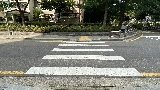

---------------------------------------------------------------
real : [39, 63, 74, 23, 40, 105, 75, 143]
test with ml :  [35.327388763427734, 55.729793548583984, 67.20094299316406, 13.693283081054688, 35.47321319580078, 94.4180908203125, 67.49785614013672, 133.35165405273438]
[35.327388763427734, 55.729793548583984, 67.20094299316406, 13.693283081054688, 35.47321319580078, 94.4180908203125, 67.49785614013672, 133.35165405273438]


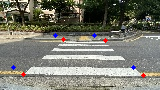

./new/test8_resized/2.jpg


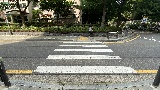

---------------------------------------------------------------
real : [37, 65, 72, 31, 39, 102, 72, 139]
test with ml :  [36.97643280029297, 58.179039001464844, 70.17920684814453, 14.301039695739746, 37.173954010009766, 98.93207550048828, 70.19232177734375, 139.44883728027344]
[36.97643280029297, 58.179039001464844, 70.17920684814453, 14.301039695739746, 37.173954010009766, 98.93207550048828, 70.19232177734375, 139.44883728027344]


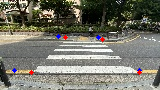

./new/test8_resized/3.jpg


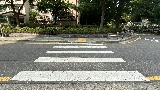

---------------------------------------------------------------
real : [39, 60, 82, 6, 42, 100, 81, 152]
test with ml :  [40.275142669677734, 63.4822883605957, 76.5698471069336, 15.565286636352539, 40.45449447631836, 107.59956359863281, 76.82524108886719, 151.97340393066406]
[40.275142669677734, 63.4822883605957, 76.5698471069336, 15.565286636352539, 40.45449447631836, 107.59956359863281, 76.82524108886719, 151.97340393066406]


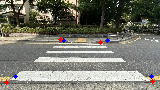

./new/test8_resized/4.jpg


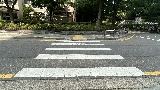

---------------------------------------------------------------
real : [36, 56, 75, 13, 40, 99, 75, 145]
test with ml :  [38.93450164794922, 61.42703628540039, 74.07988739013672, 15.063497543334961, 39.09111404418945, 103.98723602294922, 74.43750762939453, 146.96449279785156]
[38.93450164794922, 61.42703628540039, 74.07988739013672, 15.063497543334961, 39.09111404418945, 103.98723602294922, 74.43750762939453, 146.96449279785156]


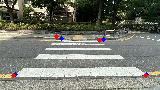

Finish


In [34]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import torch
import torch.nn as nn
import torch.optim as optim

import glob, csv, random, time, io, dill, os, cv2
import numpy as np
from PIL import Image
import PIL 
import matplotlib.pyplot as plt 
from google.colab.patches import cv2_imshow

# csv 파일 열기
file_data   = "./new/test.csv"
#file_data   = "./test.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

yy2 = []

for line in data:
  line_comp = [str(line[0])]
  tmppp = line.split(",")
  for j in range(len(tmppp)):
    tmppp[j] = tmppp[j].replace("\"","")
    tmppp[j] = tmppp[j].replace("[","")
    tmppp[j] = tmppp[j].replace("]","")
    tmppp[j] = tmppp[j].replace(" ","")
  print(tmppp)
  tmppp = list(map(int,tmppp))
  print(tmppp)
  yy2.append(tmppp)


# for line in data:
#     line_data   = line.split(',')
#     tmp_y = line_data
#     tmp_y[8] = tmp_y[8][:-1]
#     tmp_y = list(map(int, tmp_y))
#     for i in range(1,len(tmp_y)):
#       tmp_y[i] = tmp_y[i] // 8
#     label       = line_data[0]
#     yy2.append(tmp_y)

print("y2y", yy2)

def study_model_load(episode, batch_cnt, model, device):
    LoadPath_main = os.getcwd()+"/new_save/main_model_004100_000002.pth" #"+str(episode).zfill(6)+  str(batch_cnt).zfill(6)+ ".pth"
    with open(LoadPath_main, 'rb') as f:
        LoadBuffer = io.BytesIO(f.read())
    model.load_state_dict(torch.load(LoadBuffer, map_location=device))
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = train_model().to(device)
net = study_model_load(1100, 73, net, device)
net.eval()

cnt = 1

x_sum = 0
y_sum = 0
yaw_sum = 0

for idx, ccss in enumerate(yy2):
    name = "./new/test8_resized/"+str(idx+1)+".jpg"
    #name = "./test_pic_resize/"+str(idx+1)+".jpg"
    print(name)
    img = Image.open(name)
    
    image_cv = cv2.imread(name, cv2.IMREAD_UNCHANGED)
    cv2_imshow(image_cv)
    
    img = img.convert('YCbCr')
    img = np.array(img)
    img = img.transpose((2, 0, 1)) / 255.0
    img = [img.tolist()]

    x = torch.FloatTensor(img).to(device)
    
    output_x = net(x)
    #output_x = output_x.item()
    
    print("---------------------------------------------------------------")
    print("real :", ccss[1:])
    print("test with ml : ", output_x.tolist()[0] )
    
    cnt += 1
    output_x_list = output_x.tolist()
    output_x_list = output_x_list[0]
    print(output_x_list)
      
    cv2.circle(image_cv,(int(output_x_list[1]), int(output_x_list[0])), 2, (255, 0, 0), thickness = -1)
    cv2.circle(image_cv, (int(output_x_list[3]), int(output_x_list[2])), 2, (255, 0, 0), thickness = -1)
    cv2.circle(image_cv, (int(output_x_list[5]), int(output_x_list[4])), 2, (255, 0, 0), thickness = -1)
    cv2.circle(image_cv, (int(output_x_list[7]), int(output_x_list[6])), 2, (255, 0, 0), thickness = -1)
    cv2.circle(image_cv,(int(ccss[2]), int(ccss[1])), 2, (0, 0, 255), thickness = -1)
    cv2.circle(image_cv, (int(ccss[4]), int(ccss[3])), 2, (0, 0, 255), thickness = -1)
    cv2.circle(image_cv, (int(ccss[6]), int(ccss[5])), 2, (0, 0, 255), thickness = -1)
    cv2.circle(image_cv, (int(ccss[8]), int(ccss[7])), 2, (0, 0, 255), thickness = -1)
    cv2_imshow(image_cv)


print("Finish")